# Import libraries

In [1]:
import pandas as pd
import pandas_datareader as dr
import datetime
import statsmodels.api as sm
import seaborn as sns

import statsmodels

from matplotlib import rcParams
import matplotlib.pyplot as plt
import quandl

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

# functions

In [2]:
def change_date(input):
    return datetime.date(int(str(input)[0:4]), int(str(input)[4:6]), int(str(input)[6:8]))

# Date preparation

In [94]:
# Rm-Rf includes all NYSE, AMEX, and NASDAQ firms. SMB, HML, RMW, and CMA for July of year t to June 
# of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have market equity data for December 
# of t-1 and June of t, (positive) book equity data for t-1 (for SMB, HML, and RMW), non-missing 
# revenues and at least one of the following: cost of goods sold, selling, general and administrative 
# expenses, or interest expense for t-1 (for SMB and RMW), and total assets data for t-2 and t-1 (for SMB and CMA).

df = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=2)
mom = pd.read_csv('Developed_MOM_Factor.csv', skiprows=3)
mom.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
mom['Date'] = mom['Date'].str.replace(' ','')
mom['Date'] = mom['Date'].apply(change_date)

df.rename(columns={'Unnamed: 0':'date'}, inplace=True)
df['date'] = df['date'].apply(change_date)
df.set_index('date', inplace = True)

# CBOE Volatility Index: VIX
# from fred

vix = dr.get_data_fred('VIXCLS', start='1990-01-02', end='2020-10-29')
vix.reset_index(inplace = True)

vix.rename(columns = {'VIXCLS':'vix', 'DATE':'date'}, inplace = True)
vix.set_index('date', inplace = True)

#merge dataframes
data = vix.merge(df,left_index=True, right_index= True)

ValueError: invalid literal for int() with base 10: '  '

In [100]:
mom['Date'] = mom['Date'].str.replace(' ','')

In [101]:
mom['Date']

0      199011
1      199012
2      199101
3      199102
4      199103
        ...  
385      2015
386      2016
387      2017
388      2018
389      2019
Name: Date, Length: 390, dtype: object

In [5]:
ge = dr.get_data_yahoo('GE', start='1990-01-02', end='2020-10-29')

In [6]:
general_electric = ge[['Close', 'Volume']]

# Add return for General Electric

In [7]:
general_electric['return'] = 100*(general_electric['Close'] - general_electric.shift(1)['Close'])/general_electric.shift(1)['Close']

<ipython-input-7-6a299ff5a566>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  general_electric['return'] = 100*(general_electric['Close'] - general_electric.shift(1)['Close'])/general_electric.shift(1)['Close']


In [8]:
general_electric 

,Close,Volume,return
Date,,,
1990-01-02,5.348557,22990600.0,NaN
1990-01-03,5.338542,20658100.0,-0.187265
1990-01-04,5.308494,18640100.0,-0.562848
1990-01-05,5.258413,19340200.0,-0.943399
1990-01-08,5.288462,15604900.0,0.571434
...,...,...,...
2020-10-23,7.630000,132563200.0,-1.165799
2020-10-26,7.380000,104254400.0,-3.276540
2020-10-27,7.100000,98170000.0,-3.794041


In [9]:
result = data.merge(general_electric['return'], left_index=True, right_index= True)

In [10]:
result.dropna(inplace=True)

In [11]:
X = result[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'vix']]
Y = result['return']
model = sm.OLS(Y,X)
results = model.fit(cov_type = 'HC1')

In [12]:
Y.dtypes

dtype('float64')

In [13]:
X.dtypes

Mkt-RF    float64
SMB       float64
HML       float64
RMW       float64
CMA       float64
vix       float64
dtype: object

In [14]:
results.tvalues

Mkt-RF    38.884257
SMB       -4.829659
HML        7.711979
RMW        3.548436
CMA        0.135574
vix       -1.102359
dtype: float64

In [15]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.501
Model:                            OLS   Adj. R-squared (uncentered):              0.501
Method:                 Least Squares   F-statistic:                              358.7
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        01:46:05   Log-Likelihood:                         -13338.
No. Observations:                7744   AIC:                                  2.669e+04
Df Residuals:                    7738   BIC:                                  2.673e+04
Df Model:                           6                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

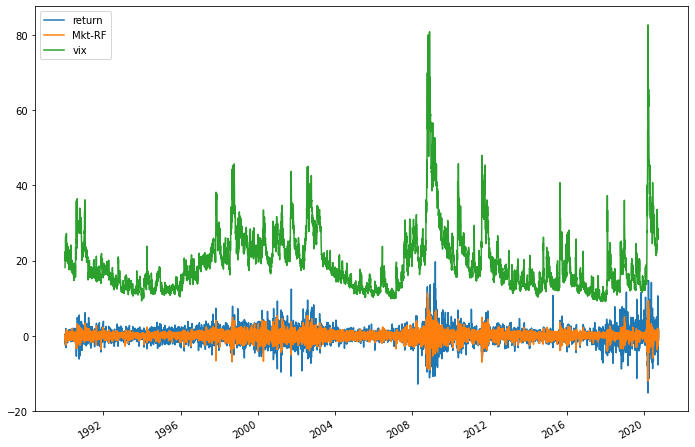

In [16]:
Y.plot()
X['Mkt-RF'].plot()
X['vix'].plot()

plt.legend(('return',  'Mkt-RF','vix'))

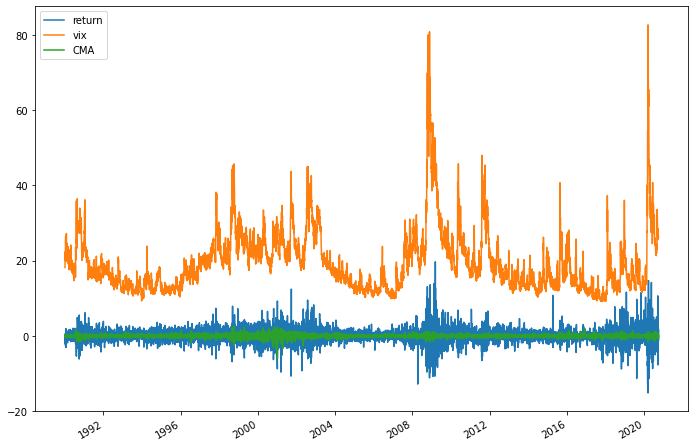

In [17]:
Y.plot()
X['vix'].plot()
X['CMA'].plot()
plt.legend(('return', 'vix', 'CMA'))

# S&P 500

In [18]:
sp = dr.get_data_yahoo('^GSPC', start='1990-01-02', end='2020-10-29')
standard_and_poor_500 = sp[['Close', 'Volume']]

In [19]:
standard_and_poor_500['return'] = 100*(standard_and_poor_500['Close'] - standard_and_poor_500.shift(1)['Close'])/standard_and_poor_500.shift(1)['Close']

<ipython-input-19-22280448ef86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_and_poor_500['return'] = 100*(standard_and_poor_500['Close'] - standard_and_poor_500.shift(1)['Close'])/standard_and_poor_500.shift(1)['Close']


## Regression OLS w/o vix

In [20]:
result = data.merge(standard_and_poor_500['return'], left_index=True, right_index= True)
result.dropna(inplace=True)
X = result[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
Y = result['return']
model = sm.OLS(Y,X)
results = model.fit(cov_type = 'HC1')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.302e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        01:46:09   Log-Likelihood:                          8839.0
No. Observations:                7744   AIC:                                 -1.767e+04
Df Residuals:                    7739   BIC:                                 -1.763e+04
Df Model:                           5                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

## Regression OLS with vix

In [21]:
result = data.merge(standard_and_poor_500['return'], left_index=True, right_index= True)
result.dropna(inplace=True)
X = result[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'vix']]
Y = result['return']
model = sm.OLS(Y,X)
results = model.fit(cov_type = 'HC1')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.103e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        01:46:09   Log-Likelihood:                          8839.5
No. Observations:                7744   AIC:                                 -1.767e+04
Df Residuals:                    7738   BIC:                                 -1.763e+04
Df Model:                           6                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

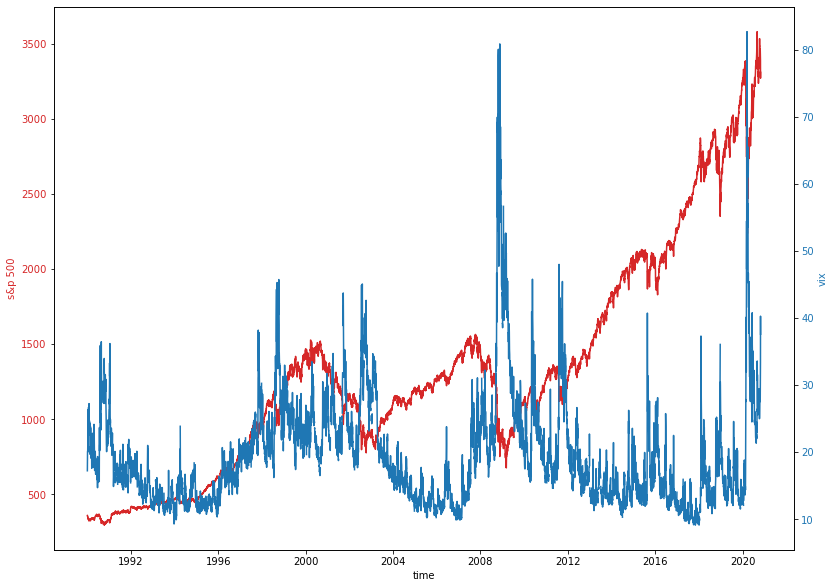

In [22]:
data1 = standard_and_poor_500['Close']
data2 = vix
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time')
ax1.set_ylabel('s&p 500', color=color)
ax1.plot(data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('vix', color=color)  # we already handled the x-label with ax1
ax2.plot(data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

## experiment approach

In [27]:
standard_and_poor_500

,Close,Volume,return
Date,,,
1990-01-02,359.690002,162070000,NaN
1990-01-03,358.760010,192330000,-0.258554
1990-01-04,355.670013,177000000,-0.861299
1990-01-05,352.200012,158530000,-0.975624
1990-01-08,353.790009,140110000,0.451447
...,...,...,...
2020-10-23,3465.389893,3646570000,0.344576
2020-10-26,3400.969971,3988080000,-1.858952
2020-10-27,3390.679932,3946990000,-0.302562


In [28]:
standard_and_poor_500['return'] = 100*(standard_and_poor_500['Close'] - standard_and_poor_500.shift(1)['Close'])/standard_and_poor_500.shift(1)['Close']

<ipython-input-28-22280448ef86>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_and_poor_500['return'] = 100*(standard_and_poor_500['Close'] - standard_and_poor_500.shift(1)['Close'])/standard_and_poor_500.shift(1)['Close']


In [29]:
data['vix_diff'] = (data['vix'] - 
                    data.shift(1)['vix'])/data.shift(1)['vix']

In [30]:
data

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff
date,,,,,,,,
1990-01-02,17.24,1.44,-0.67,-0.06,0.20,-0.45,0.026,NaN
1990-01-03,18.19,-0.06,0.73,-0.31,0.16,-0.46,0.026,0.055104
1990-01-04,19.22,-0.71,0.45,-0.25,-0.05,-0.02,0.026,0.056625
1990-01-05,20.11,-0.85,0.74,-0.23,-0.01,-0.10,0.026,0.046306
1990-01-08,20.26,0.30,-0.40,-0.24,0.06,0.31,0.026,0.007459
...,...,...,...,...,...,...,...,...
2020-09-24,28.51,0.25,-0.20,0.32,0.49,0.11,0.000,-0.002449
2020-09-25,26.38,1.72,-0.16,-1.35,-0.50,-0.70,0.000,-0.074711
2020-09-28,26.19,1.66,0.86,1.03,0.36,0.19,0.000,-0.007202


In [31]:
result_diff = data.merge(standard_and_poor_500['return'], left_index=True, right_index= True)
result_diff.dropna(inplace=True)
result_diff.describe()

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff,return
count,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000,7741.000000
mean,19.420532,0.033959,0.002555,0.003366,0.016831,0.007783,0.010408,0.002328,0.035311
std,8.120653,1.146909,0.584255,0.647082,0.458662,0.412482,0.008875,0.069437,1.149069
min,9.140000,-12.000000,-4.590000,-4.730000,-3.020000,-5.940000,0.000000,-0.295726,-11.984055
25%,13.630000,-0.440000,-0.330000,-0.290000,-0.200000,-0.200000,0.001000,-0.036761,-0.440382
50%,17.380000,0.070000,0.020000,-0.010000,0.010000,0.000000,0.009000,-0.003568,0.056598
75%,22.790000,0.550000,0.340000,0.270000,0.220000,0.200000,0.018000,0.032662,0.562247
max,82.690000,11.350000,5.710000,4.770000,4.490000,2.530000,0.034000,1.155979,11.580037


In [32]:
X = result_diff[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'vix_diff']]
Y = result_diff['return']
model = sm.OLS(Y,X)
results = model.fit(cov_type = 'HC1')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                          1.307e+05
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                        0.00
Time:                        01:48:17   Log-Likelihood:                          8835.1
No. Observations:                7741   AIC:                                 -1.766e+04
Df Residuals:                    7735   BIC:                                 -1.762e+04
Df Model:                           6                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [33]:
nom_GDP = dr.get_data_fred('GDP', start='1990-01-02', end='2020-10-29')
nom_GDP.rename(columns = {'GDP':'nom_GDP'}, inplace = True)

cpi = dr.get_data_fred('FPCPITOTLZGUSA', start='1990-01-02', end='2020-10-29')
cpi.rename(columns = {'FPCPITOTLZGUSA':'cpi'}, inplace = True)

real_GDP = dr.get_data_fred('GDPC1', start='1990-01-02', end='2020-10-29')
real_GDP.rename(columns = {'GDPC1':'real_GDP'}, inplace = True)

industrial_prod = dr.get_data_fred('INDPRO', start='1990-01-02', end='2020-10-29')
industrial_prod.rename(columns = {'INDPRO':'industrial_prod'}, inplace = True)
# The Industrial Production Index (INDPRO) is an economic indicator that measures real output
# for all facilities located in the United States manufacturing, mining, and electric, and gas
# utilities (excluding those in U.S. territories)
unemployment = dr.get_data_fred('UNRATE', start='1990-01-02', end='2020-10-29')
unemployment.rename(columns = {'UNRATE':'unemployment_rate'}, inplace = True)

month_pe_ratio_sp500 = quandl.get("MULTPL/SP500_PE_RATIO_MONTH")
month_pe_ratio_sp500.rename(columns = {'Value':'month_pe_ratio_sp500'}, inplace = True)

moody_aaa_corp_bond_yield = dr.get_data_fred('DAAA', start='1990-01-02', end='2020-10-29')
moody_aaa_corp_bond_yield.rename(columns = {'moody_aaa_corp_bond_yield':'DAAA'}, inplace = True)

moody_baa_corp_bond_yield = dr.get_data_fred('DBAA', start='1990-01-02', end='2020-10-29')
moody_baa_corp_bond_yield.rename(columns = {'moody_aaa_corp_bond_yield':'DBAA'}, inplace = True)

ICE_BofA_BBB_US_Corp_Index_Effective_Yield = dr.get_data_fred('BAMLC0A4CBBBEY', start='1990-01-02', end='2020-10-29')
ICE_BofA_BBB_US_Corp_Index_Effective_Yield.rename(columns = {'BAMLC0A4CBBBEY':'ICE_BofA_BBB_US_Corp_Index_Effective_Yield'}, inplace = True)

three_month_Treasury_Bill_Minus_Federal_Funds_Rate = dr.get_data_fred('TB3SMFFM', start='1990-01-02', end='2020-10-29')
three_month_Treasury_Bill_Minus_Federal_Funds_Rate.rename(columns = {'TB3SMFFM':'three_month_Treasury_Bill_Minus_Federal_Funds_Rate'}, inplace = True)

ten_month_Treasury_Bill_Minus_Federal_Funds_Rate = dr.get_data_fred('T10YFF', start='1990-01-02', end='2020-10-29')
ten_month_Treasury_Bill_Minus_Federal_Funds_Rate.rename(columns = {'T10YFF':'ten_month_Treasury_Bill_Minus_Federal_Funds_Rate'}, inplace = True)


In [41]:
nom_GDP.index[0]

Timestamp('1990-04-01 00:00:00')

In [104]:
data = result_diff.merge(unemployment, left_index=True, right_index= True).merge(industrial_prod, left_index=True, right_index= True).merge(month_pe_ratio_sp500, left_index=True, right_index= True).merge(moody_aaa_corp_bond_yield, left_index=True, right_index= True).merge(moody_baa_corp_bond_yield, left_index=True, right_index= True).merge(three_month_Treasury_Bill_Minus_Federal_Funds_Rate, left_index=True, right_index= True)



In [103]:
result_diff

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff,return
1990-01-03,18.19,-0.06,0.73,-0.31,0.16,-0.46,0.026,0.055104,-0.258554
1990-01-04,19.22,-0.71,0.45,-0.25,-0.05,-0.02,0.026,0.056625,-0.861299
1990-01-05,20.11,-0.85,0.74,-0.23,-0.01,-0.10,0.026,0.046306,-0.975624
1990-01-08,20.26,0.30,-0.40,-0.24,0.06,0.31,0.026,0.007459,0.451447
1990-01-09,22.20,-1.01,0.87,0.08,-0.11,0.14,0.026,0.095755,-1.178669
...,...,...,...,...,...,...,...,...,...
2020-09-24,28.51,0.25,-0.20,0.32,0.49,0.11,0.000,-0.002449,0.298746
2020-09-25,26.38,1.72,-0.16,-1.35,-0.50,-0.70,0.000,-0.074711,1.597672
2020-09-28,26.19,1.66,0.86,1.03,0.36,0.19,0.000,-0.007202,1.611059
2020-09-29,26.27,-0.42,0.42,-1.32,-0.78,-0.59,0.000,0.003055,-0.481266


# Add apple returns as dependent variable

In [147]:
aapl = dr.get_data_yahoo('AAPL', start='1990-01-02', end='2020-10-29')

In [163]:
aapl['apple_return'] = 100*(aapl['Close'] - aapl.shift(1)['Close'])/aapl.shift(1)['Close']



In [151]:
aapl.dropna(inplace=True)


In [161]:
aapl['return']

Date
1990-01-03    0.671138
1990-01-04    0.333332
1990-01-05    0.332225
1990-01-08    0.662249
1990-01-09   -0.986838
                ...   
2020-10-23   -0.613390
2020-10-26    0.008694
2020-10-27    1.347236
2020-10-28   -4.631219
2020-10-29    3.705039
Name: return, Length: 7768, dtype: float64

In [166]:
data = data.merge(pd.DataFrame(aapl['apple_return']), left_index=True, right_index=True)

# Linear regression

In [280]:
model = sm.OLS(data['apple_return'],data.drop(columns=['apple_return','month_pe_ratio_sp500','industrial_prod','unemployment_rate','return', 'three_month_Treasury_Bill_Minus_Federal_Funds_Rate', 'DBAA', 'vix']))
results = model.fit(cov_type = 'HC1')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           apple_return   R-squared (uncentered):                   0.258
Model:                            OLS   Adj. R-squared (uncentered):              0.231
Method:                 Least Squares   F-statistic:                              11.20
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                    2.53e-13
Time:                        05:56:13   Log-Likelihood:                         -555.62
No. Observations:                 234   AIC:                                      1127.
Df Residuals:                     226   BIC:                                      1155.
Df Model:                           8                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

In [179]:
model = sm.OLS(data['return'],data.drop(columns=['apple_return','month_pe_ratio_sp500','industrial_prod','unemployment_rate','return', 'three_month_Treasury_Bill_Minus_Federal_Funds_Rate', 'DBAA', 'vix']))
results = model.fit(cov_type = 'HC1')
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                 return   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                              7260.
Date:                Thu, 12 Nov 2020   Prob (F-statistic):                   7.70e-268
Time:                        05:17:55   Log-Likelihood:                          303.29
No. Observations:                 234   AIC:                                     -590.6
Df Residuals:                     226   BIC:                                     -562.9
Df Model:                           8                                                  
Covariance Type:                  HC1                                                  
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

# SVR

In [108]:
import sklearn
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

In [184]:
data

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff,return,unemployment_rate,industrial_prod,month_pe_ratio_sp500,DAAA,DBAA,three_month_Treasury_Bill_Minus_Federal_Funds_Rate,apple_return
1990-02-01,24.87,0.08,0.57,-0.03,-0.22,-0.03,0.030,-0.019322,-0.088118,5.3,64.0446,14.97,9.14,10.10,-0.50,-1.102947
1990-03-01,21.90,0.26,-0.03,-0.09,0.09,-0.30,0.029,-0.004093,0.256102,5.2,64.3580,15.62,9.28,10.20,-0.38,0.735291
1990-05-01,18.43,0.42,-0.23,-0.08,-0.05,-0.13,0.031,-0.055840,0.438335,5.4,64.3973,16.37,9.64,10.55,-0.44,0.634918
1990-06-01,17.09,0.53,-0.07,0.10,0.05,-0.26,0.030,-0.016120,0.534284,5.2,64.6041,16.95,9.33,10.23,-0.56,-1.212117
1990-08-01,21.64,-0.20,-0.33,-0.11,-0.05,0.37,0.028,0.025107,-0.176893,5.7,64.7326,15.33,9.17,10.11,-0.68,0.892854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-01,57.06,-4.51,-2.04,-1.46,0.16,0.29,0.000,0.065745,-4.414243,14.7,91.2658,24.97,2.76,4.59,0.09,-5.261705
2020-05-01,37.19,-2.91,-0.90,-1.03,-0.38,0.36,0.000,0.089019,-2.805903,13.3,91.9327,27.82,2.42,3.89,0.08,-1.609932
2020-06-01,28.23,0.52,0.26,0.45,-0.04,-0.24,0.000,0.026172,0.375123,11.1,97.6071,31.29,2.45,3.76,0.08,1.229793
2020-07-01,28.62,0.41,-1.67,-2.51,-0.43,-1.22,0.000,-0.059481,0.502213,10.2,101.6989,32.33,2.40,3.58,0.04,-0.189145


In [266]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='apple_return'), data['apple_return'], test_size=0.2, random_state=42, shuffle = False)



In [110]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [289]:
svr = SVR(C=100, kernel='rbf', degree=7)
svr.fit(X_train, y_train)
cross_validate(svr, X_train, y_train, cv = 10, scoring=['neg_mean_squared_error', 'r2'])


{'fit_time': array([0.00473619, 0.00462413, 0.00390077, 0.00398898, 0.00414515,
        0.00396681, 0.00388217, 0.00378895, 0.00398588, 0.00609112]),
 'score_time': array([0.00201488, 0.00180316, 0.00180721, 0.00178409, 0.001791  ,
        0.00175691, 0.00205493, 0.00174379, 0.00177002, 0.00378084]),
 'test_neg_mean_squared_error': array([-16.29331427,  -4.64381204, -15.86657977, -15.32649363,
        -18.68813374,  -2.47937101,  -2.61052049, -16.9639417 ,
         -3.42452615,  -1.63868214]),
 'test_r2': array([-0.01052525, -0.15641607, -0.06580783,  0.17112504, -0.10280253,
         0.24157224,  0.33377181, -1.33725592, -0.61982433,  0.33683756])}

In [290]:
y_pred = svr.predict(X_test)
print('R2 : {}'.format(r2_score(y_test, y_pred)))
print('MSE : {}'.format(mean_squared_error(y_test, y_pred)))

R2 : 0.233079687944181
MSE : 4.016275586185751


## feature selection

https://scikit-learn.org/stable/modules/feature_selection.html

In [200]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(C=100, kernel='linear')
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

In [201]:
selector.support_


array([False,  True, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False])

In [202]:
selector.ranking_

array([12,  1, 11,  1,  4,  3,  1,  5,  6,  9, 10, 13,  8,  7,  2])

In [203]:
X_train.columns

Index(['vix', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF', 'vix_diff', 'return',
       'unemployment_rate', 'industrial_prod', 'month_pe_ratio_sp500', 'DAAA',
       'DBAA', 'three_month_Treasury_Bill_Minus_Federal_Funds_Rate'],
      dtype='object')

# Lasso

In [291]:
from sklearn.linear_model import Lasso

In [292]:
lasso = Lasso(alpha = 0.5)

In [293]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.5)

In [294]:
y_pred = lasso.predict(X_test)

In [295]:
print('R2 : {}'.format(r2_score(y_test, y_pred)))
print('MSE : {}'.format(mean_squared_error(y_test, y_pred)))

R2 : 0.313411177044738
MSE : 3.5955885951062503


## L1 feature selection

In [243]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel



In [247]:
X_train.shape

(156, 15)

In [256]:
X_train

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff,return,unemployment_rate,industrial_prod,month_pe_ratio_sp500,DAAA,DBAA,three_month_Treasury_Bill_Minus_Federal_Funds_Rate
1990-02-01,24.87,0.08,0.57,-0.03,-0.22,-0.03,0.030,-0.019322,-0.088118,5.3,64.0446,14.97,9.14,10.10,-0.50
1990-03-01,21.90,0.26,-0.03,-0.09,0.09,-0.30,0.029,-0.004093,0.256102,5.2,64.3580,15.62,9.28,10.20,-0.38
1990-05-01,18.43,0.42,-0.23,-0.08,-0.05,-0.13,0.031,-0.055840,0.438335,5.4,64.3973,16.37,9.64,10.55,-0.44
1990-06-01,17.09,0.53,-0.07,0.10,0.05,-0.26,0.030,-0.016120,0.534284,5.2,64.6041,16.95,9.33,10.23,-0.56
1990-08-01,21.64,-0.20,-0.33,-0.11,-0.05,0.37,0.028,0.025107,-0.176893,5.7,64.7326,15.33,9.17,10.11,-0.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-02-01,22.59,1.39,-0.14,0.91,-0.12,0.69,0.000,-0.082453,1.426611,9.8,91.9940,18.91,5.30,6.25,-0.02
2010-03-01,19.26,1.20,1.19,0.06,0.04,0.53,0.000,-0.012308,1.015851,9.9,92.5993,18.91,5.22,6.26,-0.01
2010-04-01,17.47,0.75,0.10,0.78,0.17,0.37,0.001,-0.006822,0.741380,9.9,92.9436,19.01,5.33,6.33,-0.04
2010-06-01,35.54,-1.89,-1.32,-1.55,-0.03,-0.29,0.001,0.108201,-1.716532,9.4,94.4397,16.15,4.95,6.21,-0.06


In [261]:
lasso = Lasso(alpha = 1).fit(X_train, y_train)
model = SelectFromModel(lasso, prefit=True)
X_new = model.transform(X_train)
X_new.shape


(156, 3)

In [297]:
pd.DataFrame(X_new).head(5)

,0,1,2
0,0.08,64.0446,14.97
1,0.26,64.3580,15.62
2,0.42,64.3973,16.37
3,0.53,64.6041,16.95
4,-0.20,64.7326,15.33


In [296]:
X_train.head(5)

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff,return,unemployment_rate,industrial_prod,month_pe_ratio_sp500,DAAA,DBAA,three_month_Treasury_Bill_Minus_Federal_Funds_Rate
1990-02-01,24.87,0.08,0.57,-0.03,-0.22,-0.03,0.030,-0.019322,-0.088118,5.3,64.0446,14.97,9.14,10.10,-0.50
1990-03-01,21.90,0.26,-0.03,-0.09,0.09,-0.30,0.029,-0.004093,0.256102,5.2,64.3580,15.62,9.28,10.20,-0.38
1990-05-01,18.43,0.42,-0.23,-0.08,-0.05,-0.13,0.031,-0.055840,0.438335,5.4,64.3973,16.37,9.64,10.55,-0.44
1990-06-01,17.09,0.53,-0.07,0.10,0.05,-0.26,0.030,-0.016120,0.534284,5.2,64.6041,16.95,9.33,10.23,-0.56
1990-08-01,21.64,-0.20,-0.33,-0.11,-0.05,0.37,0.028,0.025107,-0.176893,5.7,64.7326,15.33,9.17,10.11,-0.68


# PCA

In [350]:
from sklearn.decomposition import PCA
import numpy as np

In [351]:
X_st = X_train.apply(lambda x: (x - x.mean()) / x.std(), axis=0)
#X_st = X_train.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

pc = PCA(n_components=2)
pc.fit(X_st)
X_pc = pc.transform(X_st)


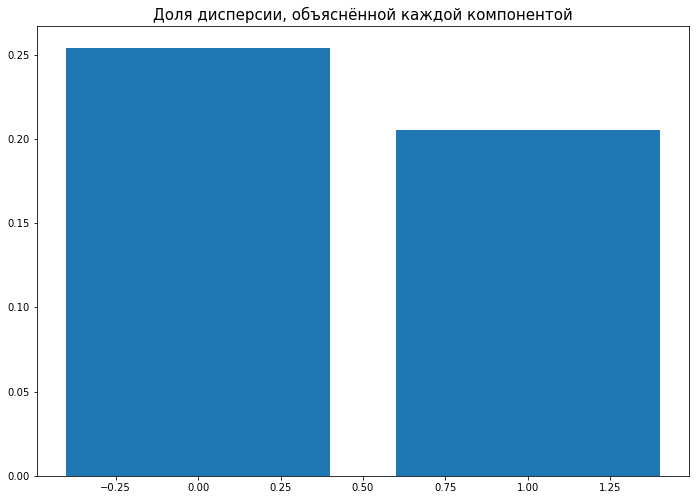

In [352]:
plt.bar(np.arange(2), pc.explained_variance_ratio_);
plt.title('Доля дисперсии, объяснённой каждой компонентой', fontsize=15);

Заметно сильное снижение доли объяснённой дисперсии при переходе от 2 к 3 компоненте,  поэтому возьмём 2 компоненты

In [353]:
features = [col for col in X_train.columns]

In [354]:
features

['vix',
 'Mkt-RF',
 'SMB',
 'HML',
 'RMW',
 'CMA',
 'RF',
 'vix_diff',
 'return',
 'unemployment_rate',
 'industrial_prod',
 'month_pe_ratio_sp500',
 'DAAA',
 'DBAA',
 'three_month_Treasury_Bill_Minus_Federal_Funds_Rate']

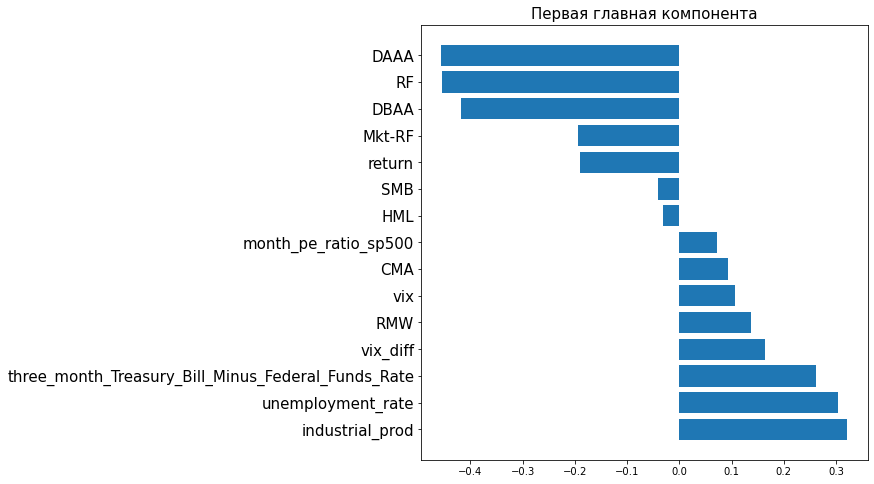

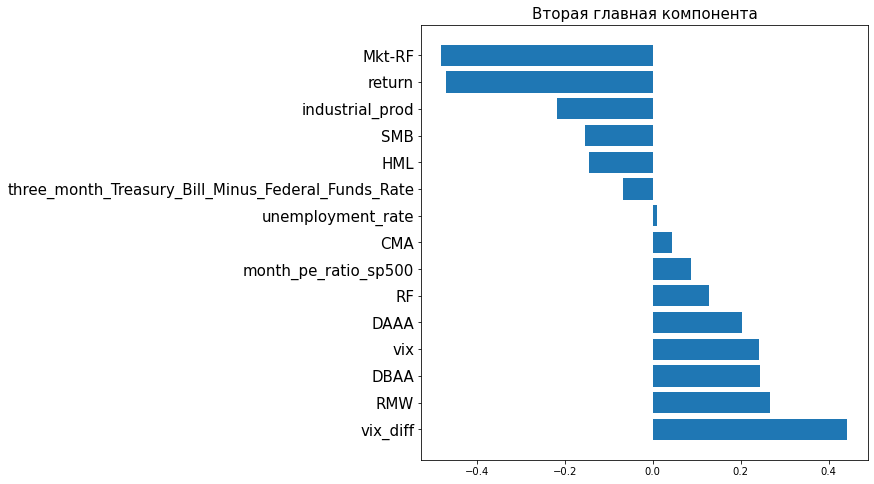

In [355]:
plt.figure(figsize=(8, 8))
plt.title('Первая главная компонента', fontsize=15)
plt.barh(
    np.array(features)[np.argsort(pc.components_[0])[::-1]], np.sort(pc.components_[0])[::-1]
);
plt.yticks(fontsize=15);

plt.figure(figsize=(8, 8))
plt.title('Вторая главная компонента', fontsize=15)
plt.barh(
    np.array(features)[np.argsort(pc.components_[1])[::-1]], np.sort(pc.components_[1])[::-1]
);
plt.yticks(fontsize=15);

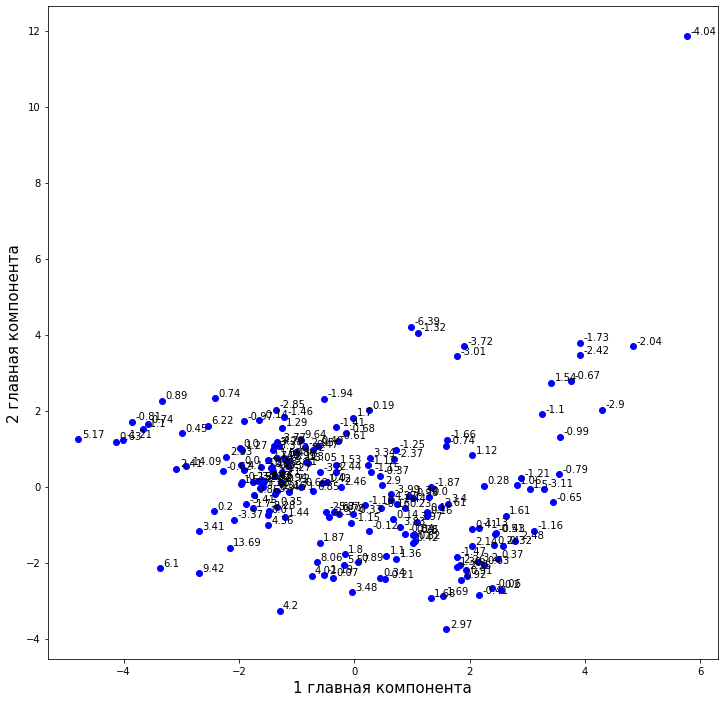

In [356]:
plt.figure(figsize=(12, 12))
for i, dat in enumerate(X_pc):
    plt.scatter(dat[0], dat[1], color='blue');
    plt.text(dat[0]+0.06, dat[1]+0.06, np.round(y_train[i],2), fontsize=10)
plt.xlabel('1 главная компонента', fontsize=15);
plt.ylabel('2 главная компонента', fontsize=15);

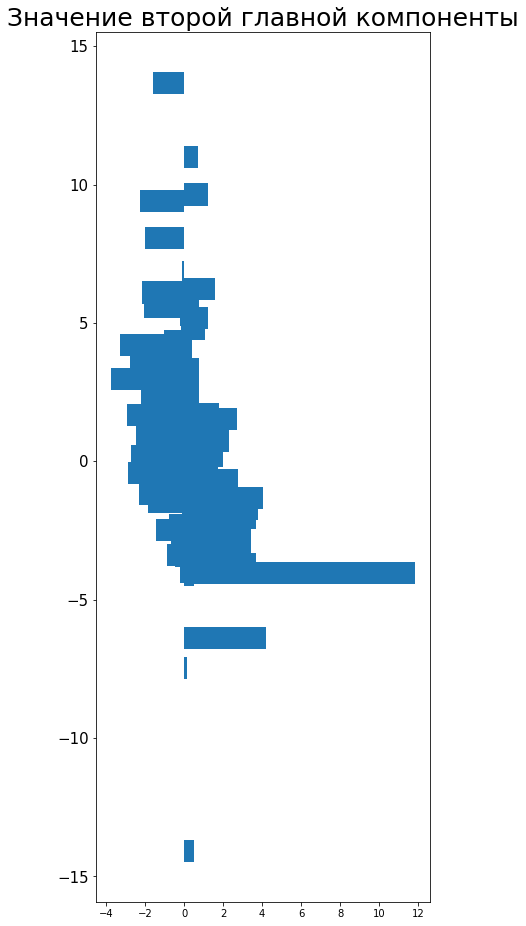

In [357]:
returns = y_train
returns = returns[np.argsort(X_pc[:, 1])]
comp2_sorted = np.sort(X_pc[:, 1])

plt.figure(figsize=(6, 16))
plt.title(f'Значение второй главной компоненты', fontsize=25);
plt.barh(returns, comp2_sorted)
plt.tick_params(axis='y', labelsize=15);

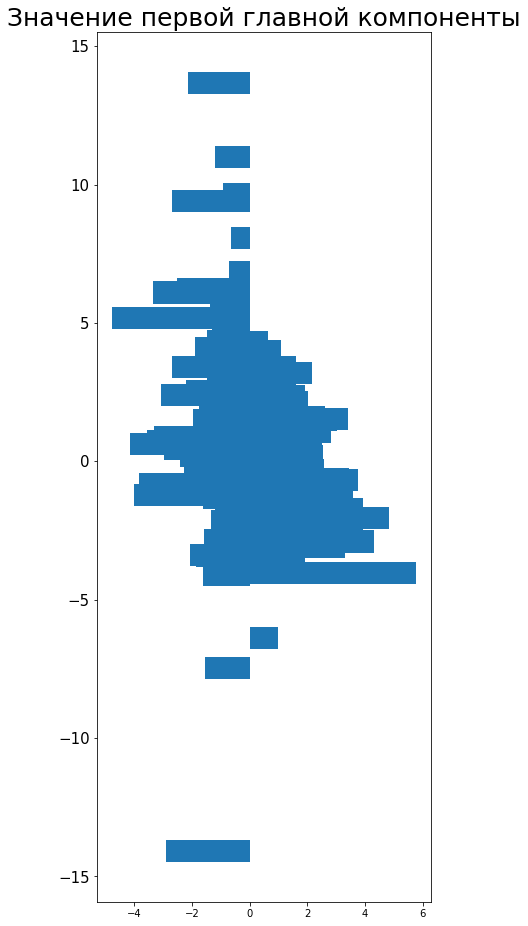

In [358]:
returns = y_train
returns = returns[np.argsort(X_pc[:, 0])]
comp2_sorted = np.sort(X_pc[:, 0])

plt.figure(figsize=(6, 16))
plt.title(f'Значение первой главной компоненты', fontsize=25);
plt.barh(returns, comp2_sorted)
plt.tick_params(axis='y', labelsize=15);

In [359]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
    ax.set_xlabel('Компоненты', fontsize=15);
    ax.set_ylabel('Признаки', fontsize=15);
    ax.autoscale_view()
    ax.invert_yaxis()

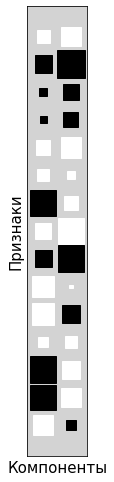

In [360]:
hinton(pc.components_)

# Random Forest

In [135]:
from sklearn.ensemble import RandomForestRegressor

In [344]:
rf = RandomForestRegressor(n_estimators=100,criterion='mse',max_depth=10,oob_score=True, bootstrap = True,
                                  n_jobs = -1, verbose = 1, random_state = 42)

In [345]:
rf.fit(X_train,y_train)
cross_validate(rf, X_train, y_train, cv = 10, scoring=['neg_mean_squared_error', 'r2'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Paral

{'fit_time': array([1.80372572, 0.09807491, 0.09328485, 0.09187818, 0.09451389,
        0.09306908, 0.09380817, 0.09088612, 0.09564114, 0.09338808]),
 'score_time': array([0.01399827, 0.01149607, 0.01123309, 0.01208997, 0.01137304,
        0.01147699, 0.01116705, 0.01178384, 0.01306677, 0.01206589]),
 'test_neg_mean_squared_error': array([-17.51759261,  -4.37018062, -16.42362709, -18.08041091,
        -17.86830123,  -3.95022947,  -2.79331715,  -7.64869712,
         -2.21518427,  -1.98511484]),
 'test_r2': array([-0.08645603, -0.08827555, -0.10322645,  0.02218993, -0.05442353,
        -0.20835635,  0.28712047, -0.05382127, -0.04779734,  0.19663883])}

In [346]:
y_pred = rf.predict(X_test)
print('R2 : {}'.format(r2_score(y_test, y_pred)))
print('MSE : {}'.format(mean_squared_error(y_test, y_pred)))

R2 : 0.32449722245300106
MSE : 3.537532219729778


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


# Feature importance from random forest

In [365]:
importances = rf.feature_importances_

In [366]:
importances

array([0.0403599 , 0.10104899, 0.0593761 , 0.09386715, 0.09696414,
       0.08420473, 0.02000082, 0.07958128, 0.1232562 , 0.06518951,
       0.08911864, 0.05300336, 0.03032234, 0.02375914, 0.03994772])

In [370]:
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train.columns), reverse=True))


[(0.1233, 'return'), (0.101, 'Mkt-RF'), (0.097, 'RMW'), (0.0939, 'HML'), (0.0891, 'industrial_prod'), (0.0842, 'CMA'), (0.0796, 'vix_diff'), (0.0652, 'unemployment_rate'), (0.0594, 'SMB'), (0.053, 'month_pe_ratio_sp500'), (0.0404, 'vix'), (0.0399, 'three_month_Treasury_Bill_Minus_Federal_Funds_Rate'), (0.0303, 'DAAA'), (0.0238, 'DBAA'), (0.02, 'RF')]


# LSTM

https://keras.io/examples/timeseries/timeseries_weather_forecasting/

In [374]:
data.head(5)

,vix,Mkt-RF,SMB,HML,RMW,CMA,RF,vix_diff,return,unemployment_rate,industrial_prod,month_pe_ratio_sp500,DAAA,DBAA,three_month_Treasury_Bill_Minus_Federal_Funds_Rate,apple_return
1990-02-01,24.87,0.08,0.57,-0.03,-0.22,-0.03,0.030,-0.019322,-0.088118,5.3,64.0446,14.97,9.14,10.10,-0.50,-1.102947
1990-03-01,21.90,0.26,-0.03,-0.09,0.09,-0.30,0.029,-0.004093,0.256102,5.2,64.3580,15.62,9.28,10.20,-0.38,0.735291
1990-05-01,18.43,0.42,-0.23,-0.08,-0.05,-0.13,0.031,-0.055840,0.438335,5.4,64.3973,16.37,9.64,10.55,-0.44,0.634918
1990-06-01,17.09,0.53,-0.07,0.10,0.05,-0.26,0.030,-0.016120,0.534284,5.2,64.6041,16.95,9.33,10.23,-0.56,-1.212117
1990-08-01,21.64,-0.20,-0.33,-0.11,-0.05,0.37,0.028,0.025107,-0.176893,5.7,64.7326,15.33,9.17,10.11,-0.68,0.892854


In [376]:
data.shape

(234, 16)

In [381]:
from keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 15)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [382]:
model.fit(X_train, y_train, epochs=200, verbose=1)

Epoch 1/200


ValueError: in user code:

    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:975 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 15]
